In [1]:
# Importing modules
import pandas as pd
import os
import matplotlib.pyplot as plt
import re
import nltk
import seaborn as sns
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
import matplotlib.pyplot as plt 
import seaborn as sns
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import f1_score


/Users/aruvi/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value
<ipython-input-19-fbe6c99930be>:23: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  movies_g.iloc[:, i] = movies_g.iloc[:, i].str.replace("[", "")
<ipython-input-19-fbe6c99930be>:24: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  movies_g.iloc[:, i] = movies_g.ilo

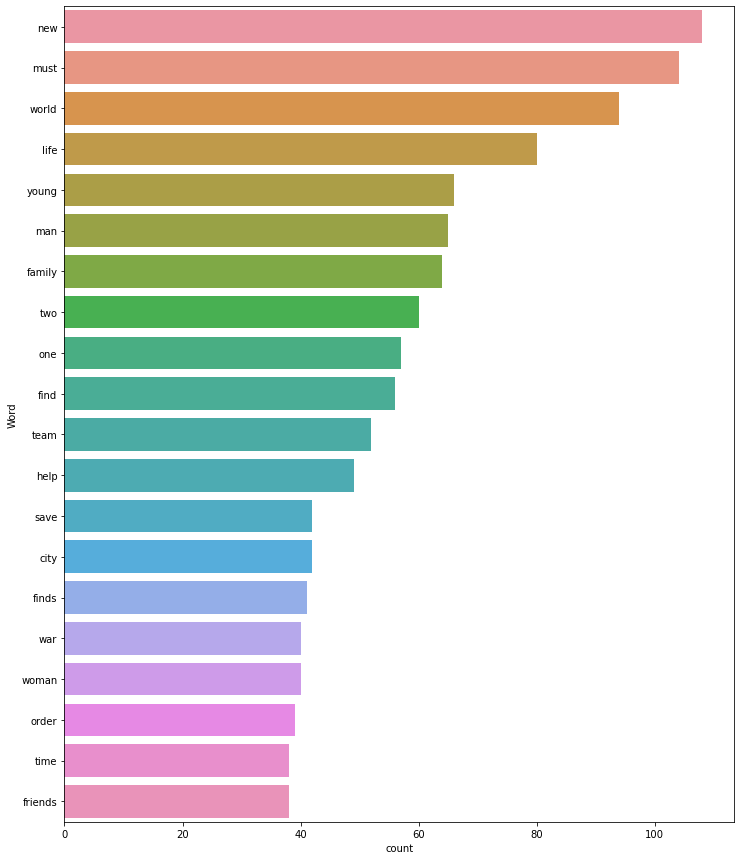

(' Adventure', ' Sci-Fi', 'Action')


In [19]:

def text_clean(text):    
    #whitespaces 
    text = ' '.join(text.split()) 
    #everything other than alphabets 
    text = re.sub("[^a-zA-Z]"," ",text) 
    #backslash-apostrophe 
    text = re.sub("\'", "", text) 
    #text to lowercase 
    text = text.lower()     
    return text

  
def stopwords(text):
    clean_text = [i for i in text.split() if not i in stop_words]
    return ' '.join(clean_text)


def prediction(i, threshold = 0.3): 
    movies = pd.read_csv('movies_filled_cleaned_processed.csv')
    movies_g = movies[['Genre', 'Movie Info']]
    for i, col in enumerate(movies_g.columns):
        movies_g.iloc[:, i] = movies_g.iloc[:, i].str.replace("'", "")
        movies_g.iloc[:, i] = movies_g.iloc[:, i].str.replace("[", "")
        movies_g.iloc[:, i] = movies_g.iloc[:, i].str.replace("]", "")

    movies_g['Genre'] = movies_g['Genre'].str.split(',')

    movies = movies_g

    movies['Genre'][0]

    movies['Movie Info Clean'] = movies['Movie Info'].apply(lambda x: text_clean(x))

    movies['Movie Info Clean'] = movies['Movie Info Clean'].apply(lambda x: stopwords(x))

    multilabel_binarizer = MultiLabelBinarizer()
    multilabel_binarizer.fit(movies['Genre'])

    # transform target variable
    y = multilabel_binarizer.transform(movies['Genre'])

    tfidf_vec = TfidfVectorizer(max_df=0.8, max_features=10000)

    # split moviesset into training and validation set
    Xtrain, Xval, Ytrain, Yval = train_test_split(movies['Movie Info Clean'], y, test_size=0.2, random_state=9)

    # create TF-IDF features
    Xtrain_tfidf = tfidf_vec.fit_transform(Xtrain)
    Xval_tfidf = tfidf_vec.transform(Xval)

    lr = LogisticRegression()
    ovrclf = OneVsRestClassifier(lr)
    ovrclf.fit(Xtrain_tfidf, Ytrain)

    #threshold = 0.3 # threshold value
    y_pred_prob = ovrclf.predict_proba(Xval_tfidf)
    y_pred = (y_pred_prob >= threshold).astype(int)

    # evaluate
    f1_score(Yval, y_pred, average="micro")

    pred = multilabel_binarizer.inverse_transform(y_pred)[i]
    
    join_words = ' '.join([text for text in movies['Movie Info Clean']]) 
    join_words = join_words.split() 
    freqdist = nltk.FreqDist(join_words) 
    words = pd.DataFrame({'word':list(freqdist.keys()), 'count':list(freqdist.values())}) 

    # selecting top 20 most frequent words 
    frw = words.nlargest(columns="count", n = 20) 

    # visualize words and frequencies
    plt.figure(figsize=(12,15)) 
    ax = sns.barplot(data=frw, x= "count", y = "word") 
    ax.set(ylabel = 'Word') 
    #shows top 20 frequent words
    plt.show()
    
    #returns the genre predictions
    return pred


print(prediction(30))